In [1]:
import pandas as pd
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import seaborn as sns


In [2]:
df = pd.read_csv('dataset_chiffre_r.csv')


In [3]:
df

,images,category
0,dataset_chiffre/0/img001-00001.png,0
1,dataset_chiffre/0/img001-00002.png,0
2,dataset_chiffre/0/img001-00003.png,0
3,dataset_chiffre/0/img001-00004.png,0
4,dataset_chiffre/0/img001-00005.png,0
...,...,...
10155,dataset_chiffre/9/img010-01012.png,9
10156,dataset_chiffre/9/img010-01013.png,9
10157,dataset_chiffre/9/img010-01014.png,9
10158,dataset_chiffre/9/img010-01015.png,9


In [4]:
df['category']

0        0
1        0
2        0
3        0
4        0
        ..
10155    9
10156    9
10157    9
10158    9
10159    9
Name: category, Length: 10160, dtype: int64

In [5]:
le = preprocessing.LabelEncoder()
le.fit(df['category'])
y = le.transform(df['category'])
print(y.shape)
print(list(le.inverse_transform([0, 1, 2])))


(10160,)
[np.int64(0), np.int64(1), np.int64(2)]


In [6]:
X = []
index = 0

for files in df.images: 
    X.append(cv2.cvtColor(cv2.imread(files), cv2.COLOR_BGR2RGB))
    index = index+1

X = np.asarray(X)
print(X.shape)

(10160, 128, 128, 3)


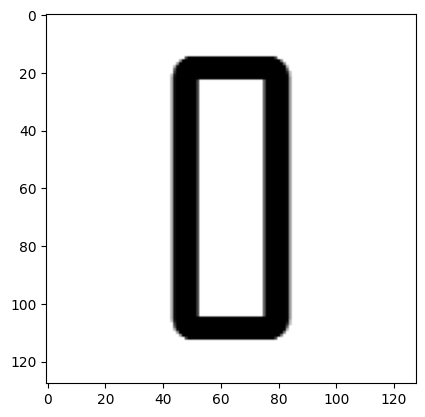

In [7]:
plt.imshow(X[0])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6807, 128, 128, 3)
(6807,)
(3353, 128, 128, 3)
(3353,)


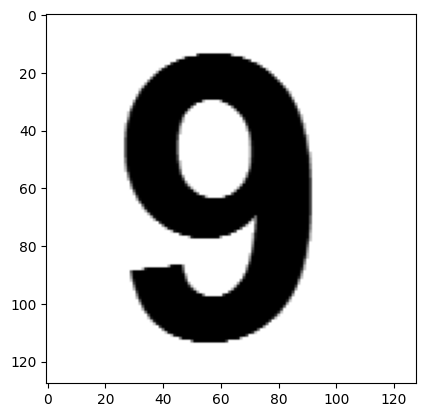

In [9]:
plt.imshow(X_train[10])

In [10]:

# model = keras.models.Sequential()
  
# model.add(keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(128,128,3)))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Dropout(0.2))

# model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Dropout(0.2))

# model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
# model.add(keras.layers.MaxPooling2D((2,2)))
# model.add(keras.layers.Dropout(0.3))

# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(100, activation='relu'))
# model.add(keras.layers.Dropout(0.1))
# # model.add(keras.layers.Dense(400, activation='relu'))
# # model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(10, activation='softmax'))  # 10 classes pour chiffres
model = keras.models.Sequential()

#model.add( keras.layers.Input((28,28,1))) #input layer

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu', input_shape = (128,128,3)) )#8 2dconvolutiv planes, kernel size 3*3
model.add( keras.layers.MaxPooling2D((2,2)))#reduce the image size on 4
# model.add( keras.layers.Dropout(0.2))#deactivate randomely some neuron outputs (regularization and avoid overfitting)

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )
model.add( keras.layers.MaxPooling2D((2,2)))
# model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(100, activation='relu'))
# model.add( keras.layers.Dropout(0.5))

model.add( keras.layers.Dense(10, activation='softmax'))

c:\Users\Clément\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\Documents\Année M1\Système intelligent\r-solution-de-sudoku\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

model.compile(optimizer='adam',#function for get down the gradient
              loss='sparse_categorical_crossentropy',#loss function for classification
              metrics=['accuracy']) #the metric 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     1,440,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,442,502 (5.50 MB)

 Trainable params: 1,442,502 (5.50 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
%%time

batch_size  = 64
epochs      =  16
history = model.fit(  X_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data=(X_test, y_test))

Epoch 1/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.2667 - loss: 132.5507 - val_accuracy: 0.4602 - val_loss: 1.3521
Epoch 2/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.5415 - loss: 1.2041 - val_accuracy: 0.8416 - val_loss: 0.7903
Epoch 3/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8833 - loss: 0.6471 - val_accuracy: 0.9099 - val_loss: 0.5128
Epoch 4/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9347 - loss: 0.4056 - val_accuracy: 0.9350 - val_loss: 0.4310
Epoch 5/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9522 - loss: 0.3479 - val_accuracy: 0.9395 - val_loss: 0.3893
Epoch 6/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.9670 - loss: 0.2860 - val_accuracy: 0.9433 - val_loss: 0.3763
Epoch 7/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9740 - loss: 0.2369 - val_accuracy: 0.9538 - val_loss: 0.3380
Epoch 8/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.9824 - loss: 0.2138 - val_

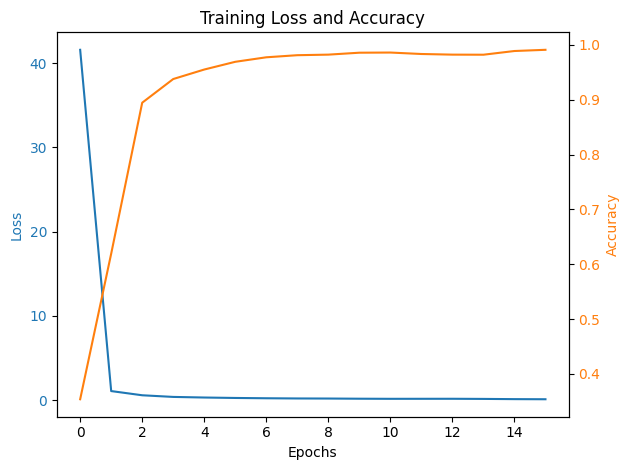

In [13]:
fig, ax1 = plt.subplots()   

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(history.history['loss'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(history.history['accuracy'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.2328
Test accuracy : 0.9672


In [15]:
y_sigmoid = model.predict(X_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


              precision    recall  f1-score   support

           0     0.9670    0.9888    0.9778       356
           1     0.9913    0.9688    0.9799       352
           2     0.9787    0.9699    0.9743       332
           3     0.9773    0.9094    0.9421       331
           4     0.9911    0.9882    0.9896       338
           5     0.9607    0.9725    0.9666       327
           6     0.9226    0.9787    0.9499       329
           7     0.9765    0.9736    0.9750       341
           8     0.9456    0.9514    0.9485       329
           9     0.9625    0.9686    0.9655       318

    accuracy                         0.9672      3353
   macro avg     0.9673    0.9670    0.9669      3353
weighted avg     0.9676    0.9672    0.9672      3353



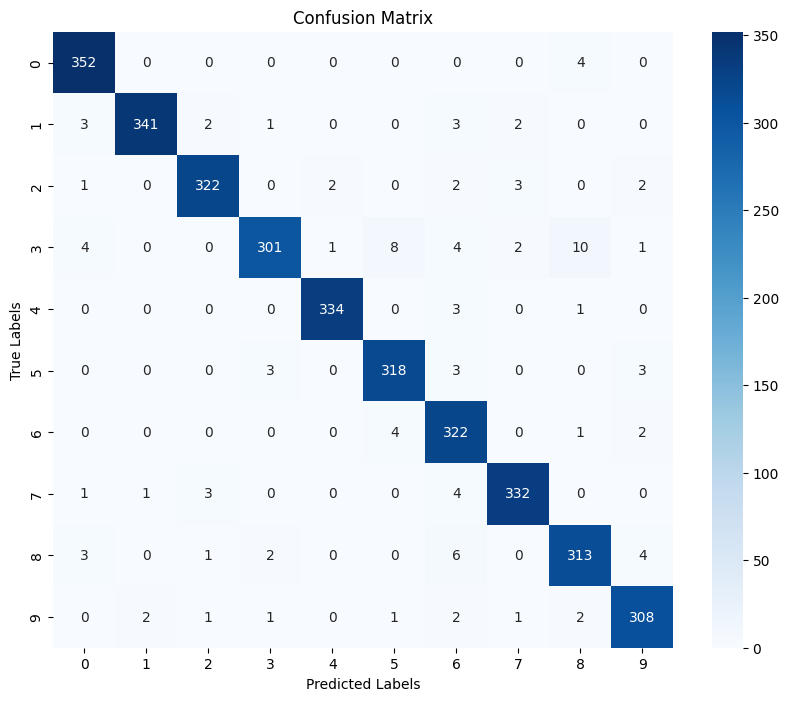

In [16]:
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# YOU NEED TO CHANGE THE FILEPATH
model_path = "c:/Image_save/model8.keras"  # Chemin où le modèle sera sauvegardé
tf.keras.models.save_model(
    model,
    filepath = model_path,
    overwrite=True,
)
model2 = keras.models.load_model(model_path)


In [18]:
# Indices des erreurs
errors = [i for i in range(len(X_test)) if y_pred[i] != y_test[i]]
print(f"Nombre d'erreurs : {len(errors)} / {len(X_test)}")


Nombre d'erreurs : 110 / 3353


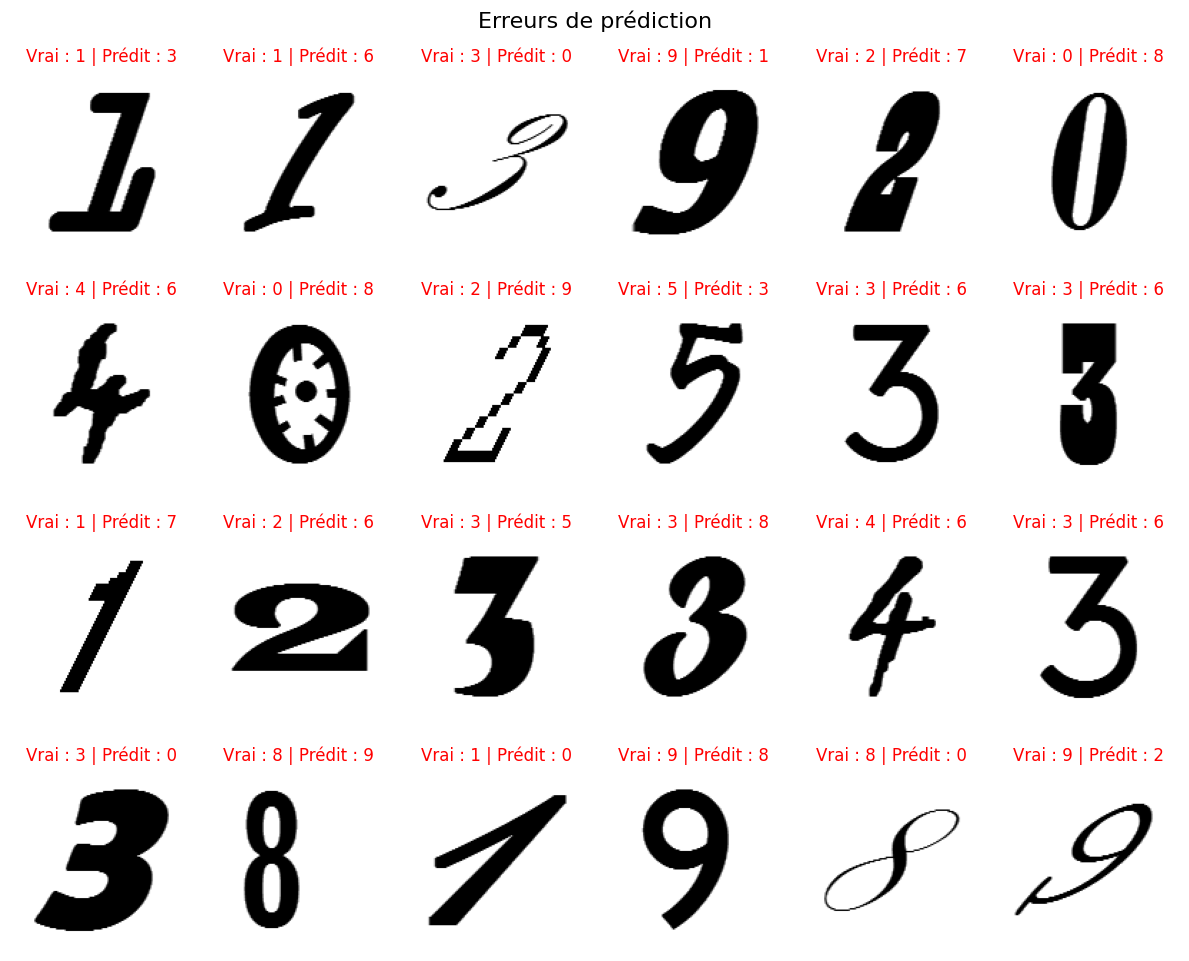

In [19]:
# Affichage des premières erreurs
plt.figure(figsize=(12, 10))
for i, idx in enumerate(errors[:24]):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"Vrai : {y_test[idx]} | Prédit : {y_pred[idx]}", color='red')
    plt.axis('off')
plt.suptitle("Erreurs de prédiction", fontsize=16)
plt.tight_layout()
plt.show()


In [20]:

model.save("sudoku_model.keras")
